# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [4]:
arms = 3
turns = 1.5
width = 0.3
noise = .5
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


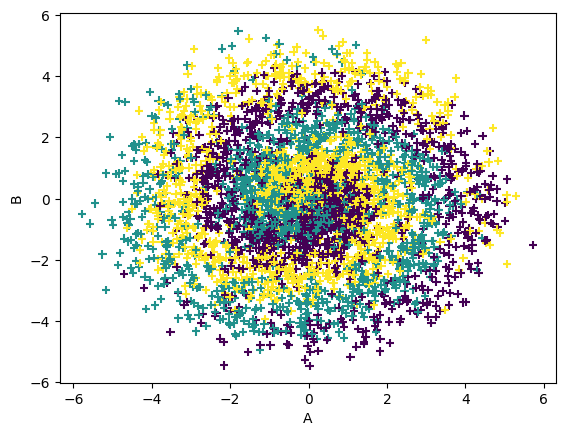

In [5]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [7]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[127  75  64]
 [ 70 140  57]
 [ 57  67 143]]
Accuracy is   0.5125
Precision is  0.5127227393617021
Recall is     0.5125
F1 is         0.5123919277790838


### Train and evaluate SVC model 

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[658 207 202]
 [216 606 244]
 [208 212 646]]
Accuracy is   0.5970615817442951
Precision is  0.596979384593906
Recall is     0.5970615817442951
F1 is         0.5969072793169224

Results for svc on test data
  Default settings
Confusion Matrix
[[151  58  57]
 [ 63 150  54]
 [ 51  53 163]]
Accuracy is   0.58
Precision is  0.5798173170077267
Recall is     0.58
F1 is         0.5798498215851615


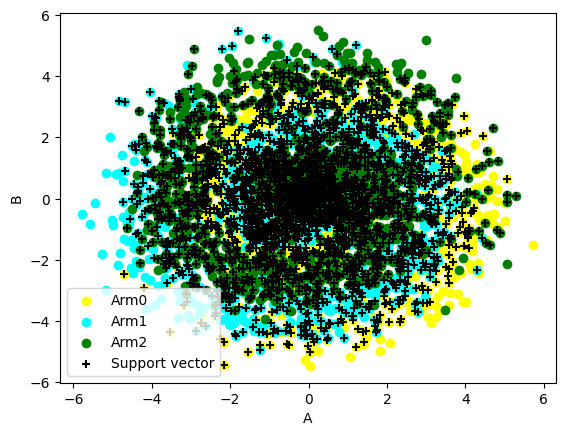

In [10]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[678 192 197]
 [154 689 223]
 [163 174 729]]
Accuracy is   0.655204751484839
Precision is  0.6563252948971725
Recall is     0.655204751484839
F1 is         0.6551830219645309

Results for NN on test data
  Default settings
Confusion Matrix
[[144  69  53]
 [ 55 163  49]
 [ 49  58 160]]
Accuracy is   0.58375
Precision is  0.5844718272635414
Recall is     0.58375
F1 is         0.5835304858893507


c:\Users\derek\OneDrive\Documents\Machine Learning\Week 5\ml-jupyterlab5-ensemble\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train and evaluate ADA boosted model

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)

y_pred = ada_model.predict(X)


print('Results for ADA on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




c:\Users\derek\OneDrive\Documents\Machine Learning\Week 5\ml-jupyterlab5-ensemble\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for ADA on train data
  Default settings
Confusion Matrix
[[595 255 217]
 [252 567 247]
 [194 254 618]]
Accuracy is   0.5564238824632698
Precision is  0.5565653522862335
Recall is     0.5564238824632698
F1 is         0.5564514844947117

Results for ADA on test data
  Default settings
Confusion Matrix
[[132  69  65]
 [ 65 144  58]
 [ 64  71 132]]
Accuracy is   0.51
Precision is  0.510150977535259
Recall is     0.51
F1 is         0.5098050293239479


### Train and evaluate Random Forest Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X,y)

y_pred = rf_model.predict(X)


print('Results for Random Forest on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)
print('Results for Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for Random Forest on train data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data
  Default settings
Confusion Matrix
[[144  58  64]
 [ 61 162  44]
 [ 61  61 145]]
Accuracy is   0.56375
Precision is  0.5636906762972445
Recall is     0.56375
F1 is         0.5634564500280742


### Train and evaluate Voting model
We build it out of three different kinds of classifiers, one each of DT, SVC and NN.

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

# Build the classifiers
vc1_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
solver='lbfgs')

# Bundle into a list with names
vcList = [('DT',vc1_dt),
('SVM',vc2_svm),
('NN',vc3_nn)]


vote_model = VotingClassifier(vcList)
vote_model.fit(X,y)

y_pred = vote_model.predict(X)


print('Results for Voting Ensemble on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = vote_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




c:\Users\derek\OneDrive\Documents\Machine Learning\Week 5\ml-jupyterlab5-ensemble\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on train data
  Default settings
Confusion Matrix
[[811 132 124]
 [154 768 144]
 [148 119 799]]
Accuracy is   0.7433572991559863
Precision is  0.7437185734637591
Recall is     0.7433572991559863
F1 is         0.7433025309157477

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[162  52  52]
 [ 71 148  48]
 [ 54  57 156]]
Accuracy is   0.5825
Precision is  0.5832602766590348
Recall is     0.5825
F1 is         0.582441999365546


### Cross Validation of Decision Tree Model

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_indices, validate_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]  # Corrected from test_indices to validate_indices
    X = train_set[['A', 'B']]
    y = train_set['Class']

    X_validate = validate_set[['A', 'B']]
    y_validate = validate_set['Class']

    model = DecisionTreeClassifier()
    model.fit(X, y)
    y_validate_pred = model.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_validate_pred)
    print("Confusion Matrix")
    print(confusion_matrix(y_validate, y_validate_pred))
    print('Accuracy is', accuracy)

    accuracy_list = np.append(accuracy_list, accuracy)  # Fixed np.append usage

print("Accuracy values", accuracy_list)
print("Average of", np.average(accuracy_list))
print("Standard deviation of", np.std(accuracy_list))




Confusion Matrix
[[64 37 33]
 [33 71 29]
 [34 26 73]]
Accuracy is 0.52
Confusion Matrix
[[70 39 25]
 [36 64 33]
 [31 33 69]]
Accuracy is 0.5075
Confusion Matrix
[[79 24 31]
 [33 61 39]
 [33 34 66]]
Accuracy is 0.515
Confusion Matrix
[[62 41 30]
 [32 65 37]
 [27 30 76]]
Accuracy is 0.5075
Confusion Matrix
[[63 36 34]
 [30 75 29]
 [33 41 59]]
Accuracy is 0.4925
Confusion Matrix
[[69 27 37]
 [37 64 33]
 [26 31 76]]
Accuracy is 0.5225
Confusion Matrix
[[69 34 30]
 [41 66 26]
 [41 34 59]]
Accuracy is 0.485
Confusion Matrix
[[71 25 37]
 [28 66 39]
 [31 41 62]]
Accuracy is 0.4975
Confusion Matrix
[[70 32 31]
 [42 64 27]
 [38 20 76]]
Accuracy is 0.525
Confusion Matrix
[[63 38 32]
 [39 64 30]
 [33 39 61]]
Accuracy is 0.47117794486215536
Accuracy values [0.52       0.5075     0.515      0.5075     0.4925     0.5225
 0.485      0.4975     0.525      0.47117794]
Average of 0.5043677944862155
Standard deviation of 0.01672179588330993


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B 150 estimators|65.18|65.18|63.63|63.62|
|Random Forest|A,B 150 estimators|100.0|100.0|81.13|81.08|
|Voting|A,B|89.43|89.44|82.13|82.12|